# Main Notebook to Perform Trading

### Imports

In [1]:
import matplotlib.pyplot as plt

from data_collection import get_historical_data
from computing import compute_momentum, compute_mean_reversion, compute_signal_returns
from signals import generate_signals_momentum, generate_signals_meanreversion, generate_final_signal
from trading import build_strategy_choice_label, build_feature_matrix, track_strategy_chosen_signals
from training import train_strategy_chooser
from analysis import count_strategy_choices, build_trade_log, get_trades_for_stock
from risk_management import apply_stop_loss

### Get Data

In [2]:
# Define the ticker list
# Always include "SPY" to benchmark vs. S&P
tickers = [
    # Technology
    "AAPL",  # Apple (tech)
    "MSFT",  # Microsoft (tech)
    "GOOG",  # Alphabet (tech)
    "AMZN",  # Amazon (e-commerce/tech)
    "META",  # Meta (Facebook)
    "NVDA",  # NVIDIA (semiconductors)
    "IBM",   # IBM (enterprise tech)
    "ORCL",  # Oracle (enterprise tech)
    "INTC",  # Intel (semiconductors)
    "ADBE",  # Adobe (software)
    "CRM",   # Salesforce (enterprise software)

    # Consumer Goods & Retail
    "KO",    # Coca-Cola (beverage)
    "PEP",   # PepsiCo (beverage/food)
    "WMT",   # Walmart (retail)
    "COST",  # Costco (retail)
    "PG",    # Procter & Gamble (consumer goods)

    # Healthcare
    "JNJ",   # Johnson & Johnson (healthcare)

    # Financials
    "GS",    # Goldman Sachs (banking)

    # Automotive & Clean Energy
    "TSLA",  # Tesla (EV/clean energy)

    # Entertainment & Media
    "NFLX",  # Netflix (streaming)
    "DIS",   # Disney (entertainment)

    # Food & Beverage
    "MCD",   # McDonald's (fast food)
    "SBUX",  # Starbucks (coffee)

    # Aerospace
    "BA",    # Boeing (aerospace)

    # Benchmark
    "SPY"    # S&P 500 (benchmark)
]

# Download historical data
start_date = "2019-12-31"
end_date = "2024-12-31"
data = get_historical_data(tickers, start=start_date, end=end_date)
spy_series = data["SPY"] # S&P 500

print("Historical Data Shape:", data.shape)
display(data.tail())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Historical Data Shape: (1258, 25)


,AAPL,MSFT,GOOG,AMZN,META,NVDA,IBM,ORCL,INTC,ADBE,...,PG,JNJ,GS,TSLA,NFLX,DIS,MCD,SBUX,BA,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-23,255.270004,435.250000,195.990005,225.059998,599.849976,139.669998,221.929993,168.725281,20.200001,446.739990,...,167.091125,145.270004,570.780029,430.600006,911.450012,111.400002,291.290009,87.440002,177.690002,594.690002
2024-12-24,258.200012,439.329987,197.570007,229.050003,607.750000,140.220001,224.410004,170.989731,20.400000,447.940002,...,167.916092,145.850006,582.789978,462.279999,932.119995,112.559998,293.989990,89.910004,179.339996,601.299988
2024-12-26,259.019989,438.109985,197.100006,227.050003,603.349976,139.929993,224.889999,171.259048,20.440001,450.160004,...,169.128708,145.580002,581.229980,454.130005,924.140015,112.550003,294.799988,91.860001,180.380005,601.340027
2024-12-27,255.589996,430.529999,194.039993,223.750000,599.809998,137.009995,222.779999,168.545731,20.299999,446.480011,...,168.502518,145.050003,576.179993,431.660004,907.549988,111.550003,293.619995,92.250000,180.720001,595.010010
2024-12-30,252.199997,424.829987,192.690002,221.300003,591.239990,137.490005,220.250000,166.500763,19.820000,445.799988,...,166.077301,143.339996,573.549988,417.410004,900.429993,110.800003,289.600006,90.580002,176.550003,588.219971


### Compute Signals

In [3]:
# Compute Momentum & Mean-Reversion
momentum_df = compute_momentum(data, window=63)  # 3-month
zscore_df   = compute_mean_reversion(data, short_window=5, long_window=20)

In [4]:
# Generate separate signals
momentum_signals   = generate_signals_momentum(momentum_df, threshold=0.10) # 10%
meanrev_signals    = generate_signals_meanreversion(zscore_df, z_entry=1.0, z_exit=0.0)

In [5]:
# Compute next-day returns from each approach
momentum_returns   = compute_signal_returns(data, momentum_signals)
meanrev_returns    = compute_signal_returns(data, meanrev_signals)
label = build_strategy_choice_label(momentum_returns, meanrev_returns)

### Train Model

In [6]:
# Build features & train the "strategy chooser"
features = build_feature_matrix(data, momentum_df, zscore_df, vol_window=20)
clf = train_strategy_chooser(features, label)

Best Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
Best CV Score: 0.5167364016736401


### Results

In [7]:
# Generate the final signals day by day based on classifier
signals = generate_final_signal(
    clf,
    features,
    momentum_signals,
    meanrev_signals
)

# Apply stop-loss to the final signals
final_signals = apply_stop_loss(signals, data, 0.05)

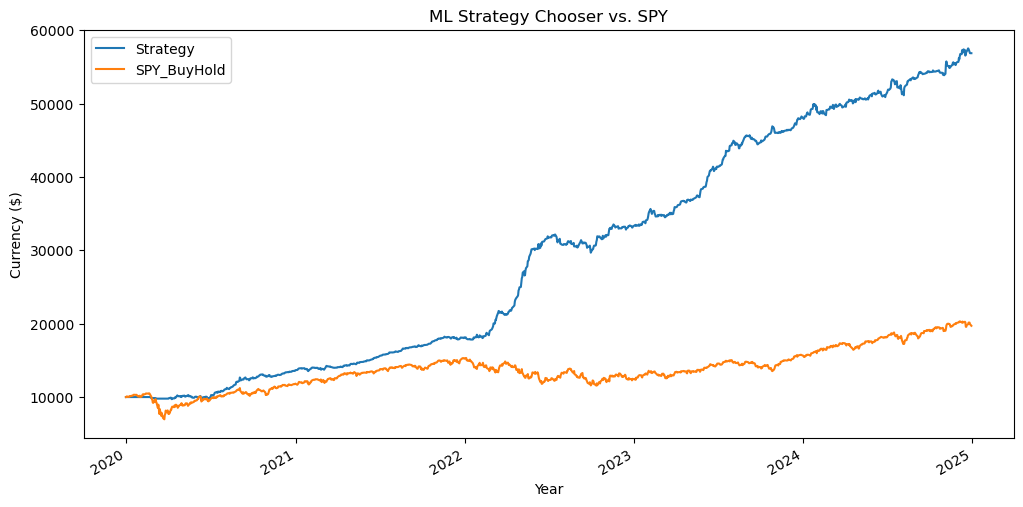

                Strategy   SPY_BuyHold
Date                                  
2024-12-23  57525.359562  19929.000616
2024-12-24  57427.653689  20150.511658
2024-12-26  57078.277814  20151.853430
2024-12-27  56870.759762  19939.724566
2024-12-30  56870.759762  19712.179640


In [8]:
# Track performance
result_df = track_strategy_chosen_signals(data.dropna(), final_signals, spy_series)

# plot
result_df[['Strategy', 'SPY_BuyHold']].plot(figsize=(12, 6), title="ML Strategy Chooser vs. SPY")
plt.ylabel("Currency ($)")
plt.xlabel("Year")
plt.show()

print(result_df.tail())

### Testing and Analysis

In [9]:
n_mom, n_mr = count_strategy_choices(clf, features)

Momentum chosen:       912 days
Mean Reversion chosen: 283 days


In [10]:
trade_log = build_trade_log(final_signals, data)
print(trade_log.head(10))

        Date Ticker     Action       Price
0 2020-02-24   AAPL  OPEN_LONG   72.441597
1 2020-02-24    SPY  OPEN_LONG  298.923492
2 2020-02-24     BA  OPEN_LONG  317.899994
3 2020-02-24   SBUX  OPEN_LONG   76.311768
4 2020-02-24     GS  OPEN_LONG  198.675735
5 2020-02-24    JNJ  OPEN_LONG  127.821838
6 2020-02-24    DIS  OPEN_LONG  131.386887
7 2020-02-24    PEP  OPEN_LONG  123.541054
8 2020-02-24   INTC  OPEN_LONG   54.746277
9 2020-02-24   ORCL  OPEN_LONG   48.836918


Total trades for AAPL: 428

Showing the first 5 trades for AAPL:

          Date Ticker       Action      Price
0   2020-02-24   AAPL    OPEN_LONG  72.441597
24  2020-02-25   AAPL   CLOSE_LONG  69.987831
62  2020-04-02   AAPL   OPEN_SHORT  59.504719
84  2020-04-03   AAPL  CLOSE_SHORT  58.649555
110 2020-04-08   AAPL   OPEN_SHORT  64.640587


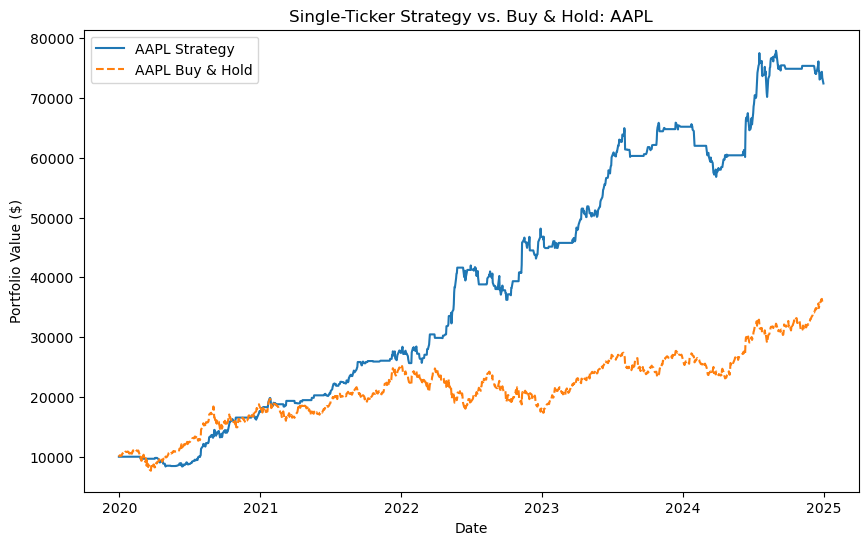

In [14]:
filtered_trades, equity, buyhold = get_trades_for_stock(
    trade_log_df=trade_log,
    final_signals=final_signals,
    price_data=data,
    ticker='AAPL', # Some good: MSFT, AAPL, Some bad: BA
    x=5,
    initial_capital=10000.0
)